# LightFM

**Ответьте на вопросы:**

__1.__ 
- В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной филтьтрации?

*В коллаборативной фильтрации учитываются только взаимодействия user-item, и никак не учитываются их характеристики. Это делает сложным рекомендации для новых пользователей и товаров. В гибридных рекомендательных системах учитываются не только взаимодействия, но и признаки пользователей и товаров. Это позволяет улучшить качество рекомендации и делать рекомендации для "холодных" пользователей и товаров*


- Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы

*Гибридные системы лучше использовать там, где постоянно обновляется контент и появляется много новых пользователей. Например, маркетплейсы - Amazon, Ozon, Joom, там постоянно обновляются товалы, добавляются новые и исчезают старые, приходят новые пользователи. Или YouTube (новые видеозаписи), hh.ru (новые вакансии), также каждый день приходит много новых пользователей.*

WARP loss объяснение на игрушечном примере  - [статья](https://medium.com/@gabrieltseng/intro-to-warp-loss-automatic-differentiation-and-pytorch-b6aa5083187a)


__2.__  Прочитайте статью про поиск на hh.ru https://habr.com/ru/company/hh/blog/347276/
Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить
Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен? 

*Основное отличие в том, что в hh используется несколько уровней, в которых каждый фильтр на основании некоего количиства признаков отбирает вакансии тем самым, с каждым разом уменьшая подборку и финальная модель уже делает финальное ранжирование по всем признаком, выдавая в итоге топ самых релевантных. Проблема при выводе в продакшен - время ранжирования XGBoost - алгоритм работает очень медленно и на пересчет модели может быть недостаточно времени*

__3.__ На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html). В работе Data Scientist'а важную часть занимает research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:  
1) Какой датасет используют авторы?  
*Используют два датасета - MovieLens - с рейтингами фильмов и датасет CrossValidated с вопросами и ответами с сервиса*

2) Что используют в качестве признаков?   
*В первом датасете содержатся рейтинги фильмов проставленные 71,6 тыс пользователей на 10,7 тыс фильмов, все фильмы описаны жанром и тегами с Tag Genome. Каждая пара фильм-тэг содержит скор релевантности (от 0 до 1), который показывает, насколько близко тэг описывает фильм. Так же, автор перевел в бинарное представление рейтинги и отметил рейтинги ниже 4 как отрицательные, а выше - как положительные взаимоддействия. Дополнительно, автор отфильтровал тэги, которые не релевантны фильму (по значению отсечки, равную 0.8)
Второй датасет содержит почти 6 тыс пользователей, 44,2 тыс вопросов, 188,9 тыс ответов и комментариев с сервиса на котором задают вопросы по машинному обучению. Также есть метаданные пользователей, тэги вопросов*

3) С какими моделями сравнивают LightFM? Опишите их основные идеи кратко  

* MF: матричная модель факторизации со смещениями пользователя и айтема и связывающей сигмоидой.  
LSI-LR: модель, основанная на контенете. Айтемы представляют в виде комбинации латентных тем, которые извлегаются с помощью латентного сементического индексирования (LSI), затем используется обычкая модель логистической регрессии.  
LSI-UP: гибридная модель, которая представляет пользовательские профили как комбинацию векторов айтемов, затем применяется LSI к результирующей матрице, чтобы получить латентное юзер-айтем представление, затем применяется SVD*

### 1. Модуль SRC  

На вебинаре было рассказано про модуль src. Он приложен в материалах. Скачайте его, изучите структуру, импортируйте функции

### 2. Работа с признаками  

У нас есть внешние данные. Что с ними не так? Чего не хватает?  

Проведите исследование внешних данных и составьте какие-нибудь содержательные выводы.  
Формально Вам нужно построить 3+ графиков (scatter plot, hist или что-то иное) и описать, что мы видим (например, товары такой-то категории болле часто покупаются в следующие дни недели или пользователи с большим достатком предпочитают такие-то товары).  
Исследуйте те закономерности, которые Вам интересно, чем менее тривиальный вывод получается, тем лучше! 

In [1]:
#!pip install lightfm

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# from metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items

In [6]:
data = pd.read_csv('retail_train.csv')

item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_test.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0
2277418,338,41260573635,636,5592737,2,1.58,369,-0.2,112,92,0.0,0.0
2277419,338,41260573635,636,7441679,1,3.69,369,0.0,112,92,0.0,0.0
2277420,338,41260573635,636,7442317,1,2.69,369,0.0,112,92,0.0,0.0


In [11]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


In [13]:
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [15]:
item_features.department.value_counts()

GROCERY            39021
DRUG GM            31529
PRODUCE             3118
COSMETICS           3011
NUTRITION           2914
MEAT                2544
MEAT-PCKGD          2427
DELI                2354
PASTRY              2149
FLORAL               938
SEAFOOD-PCKGD        563
MISC. TRANS.         490
SPIRITS              377
SEAFOOD              369
GARDEN CENTER        128
RESTAURANT           102
MISC SALES TRAN       88
SALAD BAR             48
COUP/STR & MFG        39
TRAVEL & LEISUR       28
FROZEN GROCERY        23
KIOSK-GAS             16
                      15
CHEF SHOPPE           14
RX                     9
CNTRL/STORE SUP        4
TOYS                   3
VIDEO RENTAL           3
POSTAL CENTER          3
DAIRY DELI             3
GM MERCH EXP           3
PHOTO                  2
PROD-WHS SALES         2
VIDEO                  2
CHARITABLE CONT        2
AUTOMOTIVE             2
GRO BAKERY             2
DELI/SNACK BAR         2
MEAT-WHSE              1
PORK                   1


In [31]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [32]:
item_features.loc[item_features.department == ' ']

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
52189,5126087,1,,National,,,
52190,5126088,1,,National,,,
52191,5126106,1,,National,,,
52192,5126107,1,,National,,,
55048,5977100,1,,National,,,
55054,5978648,1,,National,,,
55055,5978649,1,,National,,,
55056,5978650,1,,National,,,
55057,5978656,1,,National,,,
55058,5978657,1,,National,,,


В данных по продуктам есть категория без названия, в которой не заполнены и остальные поля

In [51]:
more_then_5_categories.department

0     39021
1     31529
2      3118
3      3011
4      2914
5      2544
6      2427
7      2354
8      2149
9       938
10      563
11      490
12      377
13      369
14      128
15      102
16       88
17       48
18       39
19       28
20       23
21       16
22       15
23       14
24        9
Name: department, dtype: int64

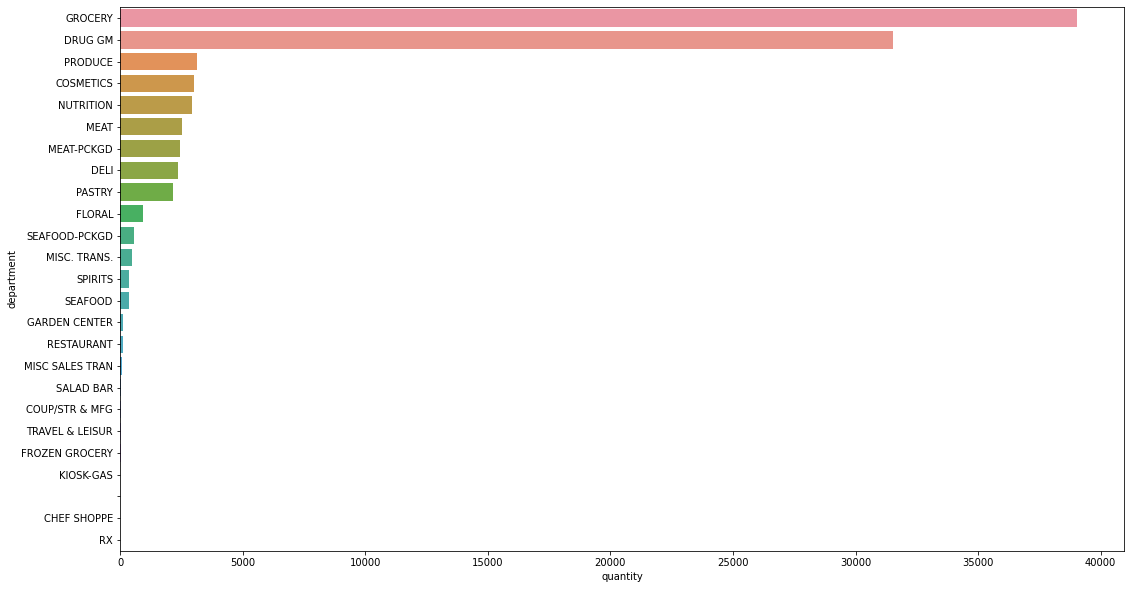

In [61]:
plt.figure(figsize=(18, 10))

categories_count = item_features.department.value_counts().reset_index().rename(columns={'index': 'department',
                                                                                        'department': 'quantity'})
more_then_5_categories = categories_count.loc[categories_count.quantity > 5]
sns.barplot(more_then_5_categories.quantity, more_then_5_categories.department,
           orient='h')

plt.show()

In [63]:
data = pd.merge(data_train, item_features, on='item_id', how='left')
data = pd.merge(data, user_features, on='user_id', how='left')
data.head(15)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,...,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,...,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,...,VEGETABLES - ALL OTHERS,CELERY,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,...,TROPICAL FRUIT,BANANAS,40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,...,ORGANICS FRUIT & VEGETABLES,ORGANIC CARROTS,1 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,...,BAKED BREAD/BUNS/ROLLS,HAMBURGER BUNS,12 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,...,BROOMS AND MOPS,SPONGES: BATH HOUSEHOLD,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,...,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,18 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,...,PNT BTR/JELLY/JAMS,PEANUT BUTTER,12 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,...,COOKIES/CONES,GRAHAM CRACKERS,11 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
data.columns

Index(['user_id', 'basket_id', 'day', 'item_id', 'quantity', 'sales_value',
       'store_id', 'retail_disc', 'trans_time', 'week_no', 'coupon_disc',
       'coupon_match_disc', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc'],
      dtype='object')

In [ ]:
sum(item_features.department.value_counts() < 5)

Самые обширные категории товаров - 'Grocery', 'Drug GM'. Есть категории, в которых менее 5 позиций, всего таких 19 

In [9]:
data_train.item_id.value_counts()

1082185     26127
6534178     17545
1029743     12737
995242      10943
1106523      8722
            ...  
505149          1
13097497        1
12757687        1
76487           1
12582342        1
Name: item_id, Length: 86865, dtype: int64

In [8]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [9]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [10]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [11]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

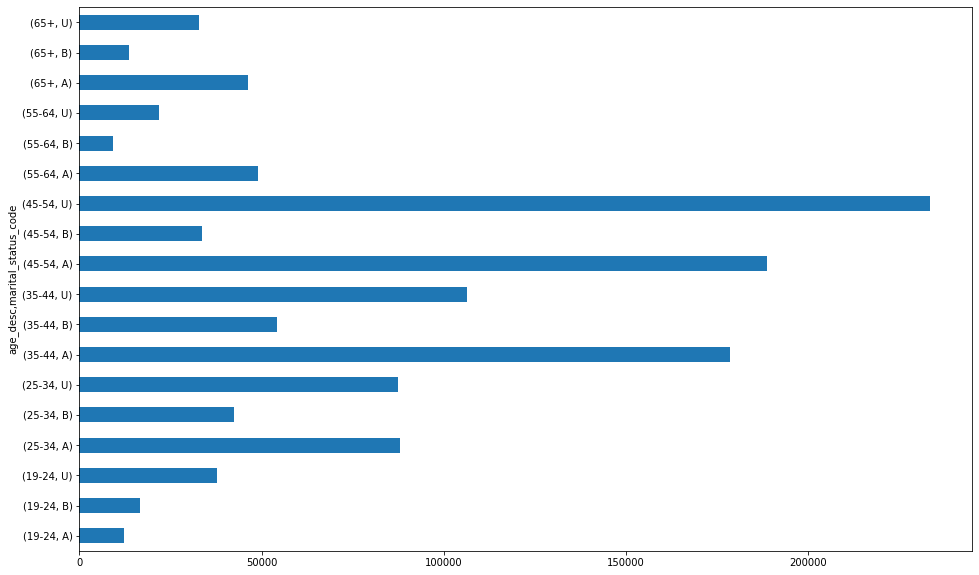

In [75]:
plt.figure(figsize=(16, 10))
data.groupby(['age_desc', 'marital_status_code'])['user_id'].count().plot.barh()
plt.show()

Больше всего покупок делают люди в возрасте 35-44 с семейным статусом "А" и 44-54 со статусами "А" и "U"

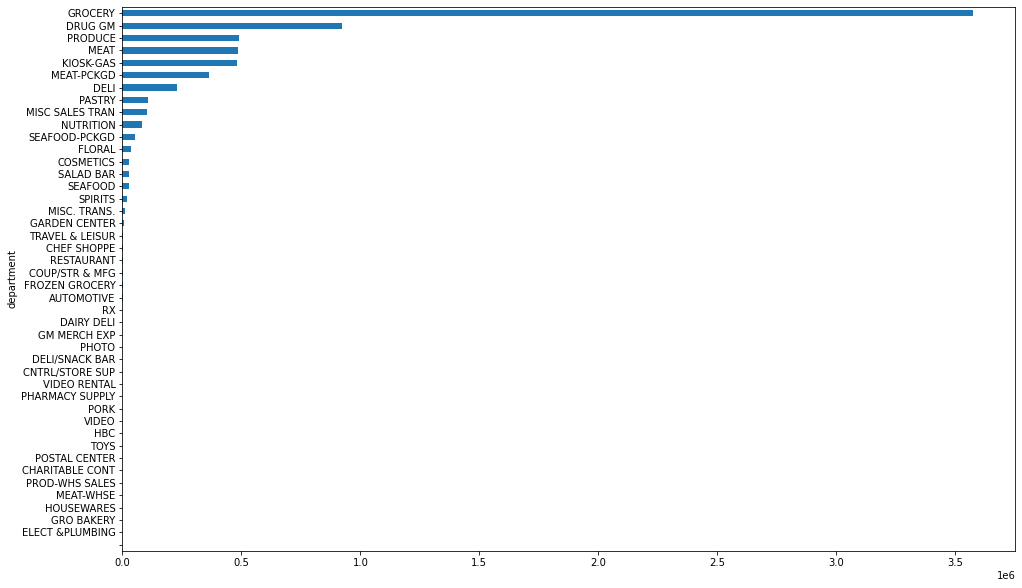

In [83]:
plt.figure(figsize=(16, 10))
data.groupby(['department'])['sales_value'].sum().sort_values().plot.barh()
plt.show()

Видно, что по сумме покупок по-прежнему самые денежные - Grocery и Drug DM. Посмотрим, как в этих категориях меняется сумма покупок в каждую неделю

In [80]:
data.week_no.nunique()

91

In [84]:
data.department.unique()

array(['PRODUCE', 'GROCERY', 'DRUG GM', 'MEAT', 'MEAT-PCKGD', 'DELI',
       'SEAFOOD-PCKGD', ' ', 'PASTRY', 'NUTRITION', 'VIDEO RENTAL',
       'MISC SALES TRAN', 'FLORAL', 'SEAFOOD', 'SALAD BAR', 'AUTOMOTIVE',
       'SPIRITS', 'COSMETICS', 'MISC. TRANS.', 'GARDEN CENTER',
       'CHEF SHOPPE', 'TRAVEL & LEISUR', 'COUP/STR & MFG', 'KIOSK-GAS',
       'FROZEN GROCERY', 'RESTAURANT', 'HOUSEWARES', 'PORK',
       'POSTAL CENTER', 'GM MERCH EXP', 'CNTRL/STORE SUP',
       'PROD-WHS SALES', 'DAIRY DELI', 'HBC', 'CHARITABLE CONT', 'RX',
       'TOYS', 'PHOTO', 'DELI/SNACK BAR', 'GRO BAKERY', 'PHARMACY SUPPLY',
       'ELECT &PLUMBING', 'MEAT-WHSE', 'VIDEO'], dtype=object)

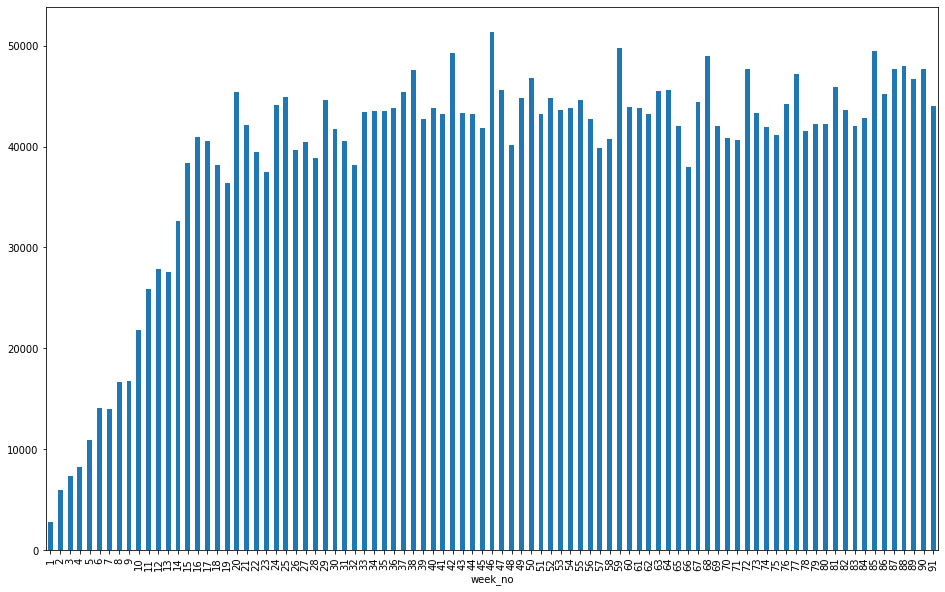

In [88]:
plt.figure(figsize=(16, 10))
data.loc[data.department == 'GROCERY'].groupby('week_no')['sales_value'].sum().sort_index().plot.bar()

plt.show()

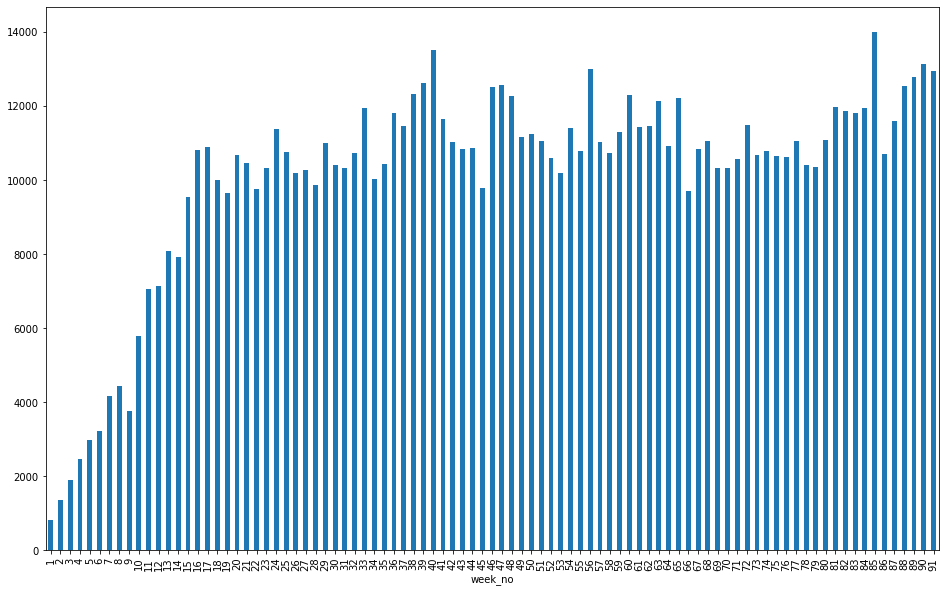

In [89]:
plt.figure(figsize=(16, 10))
data.loc[data.department == 'DRUG GM'].groupby('week_no')['sales_value'].sum().sort_index().plot.bar()

plt.show()

Видно, что в примерно 15 первых недель сумма покупок ниже, чем дальше, скорее всего это связано с тем, что в первое время сеть набирала обороты по продажам

In [ ]:
На графике 

## 1. Filter items

In [12]:
n_items_train_before = data_train['item_id'].nunique()
n_items_test_before = data_test['item_id'].nunique()
n_users_train_before = data_train['user_id'].nunique()
n_users_test_before = data_test['user_id'].nunique()

data_train_filtered = prefilter_items(data_train, take_n_popular=5000, item_features=item_features)
data_test_filtered = prefilter_items(data_test, take_n_popular=5000, item_features=item_features)

n_items_train_after = data_train_filtered['item_id'].nunique()
n_items_test_after = data_test_filtered['item_id'].nunique()
n_users_train_after = data_train_filtered['user_id'].nunique()
n_users_test_after = data_test_filtered['user_id'].nunique()
print('Decreased # items_train from {} to {}'.format(n_items_train_before, n_items_train_after))
print('Decreased # items_test from {} to {}'.format(n_items_test_before, n_items_test_after))
print('Decreased # users_train from {} to {}'.format(n_users_train_before, n_users_train_after))
print('Decreased # users_test from {} to {}'.format(n_users_test_before, n_users_test_after))

Decreased # items_train from 86865 to 5001
Decreased # items_test from 24329 to 5001
Decreased # users_train from 2499 to 2497
Decreased # users_test from 2042 to 1990


# 2. Prepare data set

## 2.1 Prepare csr train matrix

In [13]:
user_item_matrix = pd.pivot_table(data_train_filtered,
                                  index='user_id', columns='item_id',
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count',
                                  fill_value=0
                                  )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,117847,818981,819255,819308,819400,819487,819590,819594,819840,819845,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2 Prepare CSR test matrix

In [14]:
# Warm start - берем только те user_id, которые есть в train
data_test = data_test[data_test['user_id'].isin(data_train['user_id'])]

test_user_item_matrix = pd.pivot_table(data_test_filtered,
                                       index='user_id', columns='item_id',
                                       values='quantity', # Можно пробовать другие варианты
                                       aggfunc='count',
                                       fill_value=0
                                       )

test_user_item_matrix = test_user_item_matrix.astype(float)

test_sparse_user_item_matrix = csr_matrix(test_user_item_matrix).tocsr() # необходимый тип матрицы для implicit

test_user_item_matrix.head(2)

item_id,819210,819308,819423,819487,819840,819845,819978,820321,820347,820352,...,17381676,17381995,17827241,17900997,17901020,17903379,17903423,17959083,18000012,18024556
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## 3. Prepare user and item features

In [16]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)
user_feat.head(10)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
8,25-34,U,25-34K,Unknown,2 Adults Kids,3,1
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# test_user_feat = pd.DataFrame(test_user_item_matrix.index)
# test_user_feat = test_user_feat.merge(user_features, on='user_id', how='left')
# test_user_feat.set_index('user_id', inplace=True)
# test_user_feat.head(10)

In [18]:
user_feat.shape\
    # , test_user_feat.shape

(2497, 7)

In [19]:
item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

item_feat.head(5)

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
item_id,,,,,,
117847,450.0,NUTRITION,National,REFRIGERATED,SOY/RICE MILK,64 OZ
818981,194.0,GROCERY,National,COLD CEREAL,ALL FAMILY CEREAL,10.4 OZ
819255,1007.0,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,ROLLS - PORK,1 LB
819308,2879.0,MEAT,National,BEEF,CHOICE BEEF,
819400,584.0,GROCERY,National,DOG FOODS,DOG TREATS (SOFT TREATS),5.6 OZ


In [20]:
# test_item_feat = pd.DataFrame(test_user_item_matrix.columns)
# test_item_feat = test_item_feat.merge(item_features, on='item_id', how='left')
# test_item_feat.set_index('item_id', inplace=True)
#
# test_item_feat.head(5)

In [21]:
item_feat.shape\
    # , test_item_feat.shape

(5001, 6)

## Encoding features

In [22]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [23]:
item_feat_lightfm.head(2)

,manufacturer_2.0,manufacturer_5.0,manufacturer_16.0,manufacturer_20.0,manufacturer_26.0,manufacturer_33.0,manufacturer_35.0,manufacturer_36.0,manufacturer_42.0,manufacturer_43.0,...,curr_size_of_product_L 16 OZ,curr_size_of_product_L 7.75 OZ,curr_size_of_product_L 13.25 OZ,curr_size_of_product_LB,curr_size_of_product_N 12 OZ,curr_size_of_product_N 40 OZ,curr_size_of_product_PINT,curr_size_of_product_PK,curr_size_of_product_PT,curr_size_of_product_QT
item_id,,,,,,,,,,,,,,,,,,,,,
117847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
818981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Init model

In [24]:
model = LightFM(no_components=40,
                loss='bpr',
                # loss='warp',
                learning_rate=0.01,
                item_alpha=0.5,
                user_alpha=0.5,
                random_state=42)

## Train

In [25]:
%%time

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=20,
          num_threads=4,
          verbose=False)

CPU times: user 1min 16s, sys: 941 ms, total: 1min 17s
Wall time: 1min 23s


## Evaluation

In [26]:
user_emb = model.get_user_representations(features=csr_matrix(user_feat_lightfm.values).tocsr())

In [27]:
user_emb[0]  # biases

array([-14.830458,   0.      ,   0.      , ..., -15.662933,  -9.904337,
         0.      ], dtype=float32)

In [28]:
user_emb[1]  # embeddings

array([[-4.60977162e-06, -2.60512661e-06,  1.70567910e-06, ...,
        -2.43383965e-05, -2.76305127e-06,  9.10889503e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.91883628e-05,  1.45058129e-06, -2.02712181e-05, ...,
         1.36510835e-05, -1.74547085e-06,  2.09315149e-05],
       [ 9.85287261e-06,  2.04165517e-05, -4.74279987e-05, ...,
        -2.74393878e-05,  1.01068317e-05,  8.09071753e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]], dtype=float32)

In [29]:
item_emb = model.get_item_representations(features=csr_matrix(item_feat_lightfm.values).tocsr())

In [30]:
item_emb[0].shape, item_emb[1].shape

((5001,), (5001, 40))

# Train precision

In [31]:
train_precision = precision_at_k(model, sparse_user_item,
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

test_precision = precision_at_k(model, test_sparse_user_item_matrix,
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

train_precision, test_precision

(0.21097319, 0.0024120605)

## Params Search

In [27]:
?LightFM

In [ ]:
# %%time
# no_components = [20, 30, 40, 50, 60]
# item_alpha = [1e-2, 1e-1, 0]
# user_alpha = [1e-2, 1e-1, 0]
# learning_rate = [1e-2, 5e-2 , 1e-1]
# loss = ['bpr', 'warp']
#
# result = pd.DataFrame(columns = ['no_components', 'item_alpha', 'user_alpha',
#                                  'learning_rate', 'loss', 'train_precision@5', 'test_precision@5'])
# i = 0
# for l in loss:
#     for c in no_components:
#         for lr in learning_rate:
#             for ia in item_alpha:
#                 for ua in user_alpha:
#                     try:
#                         model = LightFM(no_components=c,
#                                         loss=l,
#                                         learning_rate=lr,
#                                         item_alpha=ia,
#                                         user_alpha=ua,
#                                         random_state=42)
#
#                         model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
#                                   sample_weight=coo_matrix(user_item_matrix),
#                                   user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
#                                   item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
#                                   epochs=15,
#                                   num_threads=4,
#                                   verbose=False)
#
#                         train_precision = precision_at_k(model, sparse_user_item,
#                                                          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
#                                                          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
#                                                          k=5).mean()
#
#                         test_precision = precision_at_k(model, test_sparse_user_item_matrix,
#                                                          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
#                                                          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
#                                                          k=5).mean()
#
#                         result.loc[i] = [c, ia, ua, lr, l, train_precision, test_precision]
#
#                         print(f"{30*'-'}\nloss: {l}\nn_components: {c}\nitem_alpha: {ia}\nuser_alpha: {ua}\nlearning_rate: {lr}\ntrain precision@k: {train_precision:.4f}\ntest precision@k: {test_precision:.4f}")
#
#                     except ValueError:
#                         result.loc[i] = [c, ia, ua, lr, l, np.nan, np.nan]
#
#                         print(f'******Parameters failed:*****\n\loss: {l}\nn_components: {c}\nitem_alpha: {ia}\nuser_alpha: {ua}\nlearning_rate: {lr}')
#
#                     i+=1

******Parameters failed:*****
\loss: bpr
n_components: 20
item_alpha: 0.01
user_alpha: 0.01
learning_rate: 0.01
******Parameters failed:*****
\loss: bpr
n_components: 20
item_alpha: 0.01
user_alpha: 0.1
learning_rate: 0.01
******Parameters failed:*****
\loss: bpr
n_components: 20
item_alpha: 0.01
user_alpha: 0
learning_rate: 0.01
******Parameters failed:*****
\loss: bpr
n_components: 20
item_alpha: 0.1
user_alpha: 0.01
learning_rate: 0.01
******Parameters failed:*****
\loss: bpr
n_components: 20
item_alpha: 0.1
user_alpha: 0.1
learning_rate: 0.01
******Parameters failed:*****
\loss: bpr
n_components: 20
item_alpha: 0.1
user_alpha: 0
learning_rate: 0.01
******Parameters failed:*****
\loss: bpr
n_components: 20
item_alpha: 0
user_alpha: 0.01
learning_rate: 0.01
******Parameters failed:*****
\loss: bpr
n_components: 20
item_alpha: 0
user_alpha: 0.1
learning_rate: 0.01
******Parameters failed:*****
\loss: bpr
n_components: 20
item_alpha: 0
user_alpha: 0
learning_rate: 0.01
******Parameters

KeyboardInterrupt: 

In [62]:
result

,no_components,item_alpha,user_alpha,learning_rate,loss,train_precision@5,test_precision@5
0,20,0.01,0.01,0.01,bpr,0.419784,0.002613
1,20,0.01,0.10,0.01,bpr,0.199760,0.000603
2,20,0.01,0.00,0.01,bpr,0.347777,0.001910
3,20,0.10,0.01,0.01,bpr,0.201362,0.002010
4,20,0.10,0.10,0.01,bpr,0.438526,0.002814
...,...,...,...,...,...,...,...
265,60,0.10,0.10,0.10,warp,0.216099,0.001106
266,60,0.10,0.00,0.10,warp,0.276171,0.002513
267,60,0.00,0.01,0.10,warp,0.278574,0.003015
268,60,0.00,0.10,0.10,warp,0.061674,0.002613


In [28]:
%%time

# так как на тесте результат не очень хороший, попробуем еще поменять параметр epochs в fit
no_components = [20, 40, 60]
item_alpha = [1e-1, 5e-1, 8e-1]
user_alpha = [5e-2, 1e-1, 8e-1]
learning_rate = [1e-2, 5e-2 , 1e-1]
loss = ['bpr', 'warp']
epochs = [5, 10, 15, 20]

result = pd.DataFrame(columns = ['no_components', 'item_alpha', 'user_alpha',
                                 'learning_rate', 'loss', 'epochs', 'train_precision@5', 'test_precision@5'])
i = 0
for l in loss:
    for c in no_components:
        for lr in learning_rate:
            for ia in item_alpha:
                for ua in user_alpha:
                    model = LightFM(no_components=c,
                                    loss=l,
                                    learning_rate=lr,
                                    item_alpha=ia,
                                    user_alpha=ua,
                                    random_state=42)
                    for e in epochs:
                        try:
                            model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                                      sample_weight=coo_matrix(user_item_matrix),
                                      user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                      item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                      epochs=e,
                                      num_threads=4,
                                      verbose=False)

                            train_precision = precision_at_k(model, sparse_user_item,
                                                             user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                                             item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                                             k=5).mean()

                            test_precision = precision_at_k(model, test_sparse_user_item_matrix,
                                                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                                            k=5).mean()

                            result.loc[i] = [c, ia, ua, lr, l, e, train_precision, test_precision]

                            print(f"{30*'-'}\nloss: {l}\nn_components: {c}\nitem_alpha: {ia}\nuser_alpha: {ua}\nlearning_rate: {lr}\nepochs: {e}\ntrain precision@k: {train_precision:.4f}\ntest precision@k: {test_precision:.4f}")

                        except ValueError:
                            result.loc[i] = [c, ia, ua, lr, l, e, np.nan, np.nan]

                            print(f'******Parameters failed:*****\n\loss: {l}\nn_components: {c}\nitem_alpha: {ia}\nuser_alpha: {ua}\nlearning_rate: {lr}\nepoch: {e}')

                        i+=1

------------------------------
loss: bpr
n_components: 20
item_alpha: 0.1
user_alpha: 0.05
learning_rate: 0.01
epochs: 5
train precision@k: 0.4385
test precision@k: 0.0028
------------------------------
loss: bpr
n_components: 20
item_alpha: 0.1
user_alpha: 0.05
learning_rate: 0.01
epochs: 10
train precision@k: 0.4385
test precision@k: 0.0028
------------------------------
loss: bpr
n_components: 20
item_alpha: 0.1
user_alpha: 0.05
learning_rate: 0.01
epochs: 15
train precision@k: 0.4385
test precision@k: 0.0028
------------------------------
loss: bpr
n_components: 20
item_alpha: 0.1
user_alpha: 0.05
learning_rate: 0.01
epochs: 20
train precision@k: 0.4385
test precision@k: 0.0028
------------------------------
loss: bpr
n_components: 20
item_alpha: 0.1
user_alpha: 0.1
learning_rate: 0.01
epochs: 5
train precision@k: 0.4385
test precision@k: 0.0028
------------------------------
loss: bpr
n_components: 20
item_alpha: 0.1
user_alpha: 0.1
learning_rate: 0.01
epochs: 10
train precision@k

In [29]:
result

,no_components,item_alpha,user_alpha,learning_rate,loss,epochs,train_precision@5,test_precision@5
0,20,0.1,0.05,0.01,bpr,5,0.438526,0.002814
1,20,0.1,0.05,0.01,bpr,10,0.438526,0.002814
2,20,0.1,0.05,0.01,bpr,15,0.438526,0.002814
3,20,0.1,0.05,0.01,bpr,20,0.438526,0.002814
4,20,0.1,0.10,0.01,bpr,5,0.438526,0.002814
...,...,...,...,...,...,...,...,...
643,60,0.8,0.10,0.10,warp,20,0.199920,0.000905
644,60,0.8,0.80,0.10,warp,5,0.208410,0.002915
645,60,0.8,0.80,0.10,warp,10,0.131438,0.001508
646,60,0.8,0.80,0.10,warp,15,0.147537,0.002010


In [34]:
result.loc[result['test_precision@5'].values > 0.015]

,no_components,item_alpha,user_alpha,learning_rate,loss,epochs,train_precision@5,test_precision@5
48,20,0.5,0.05,0.05,bpr,5,0.205046,0.015477
52,20,0.5,0.10,0.05,bpr,5,0.205046,0.015477
70,20,0.8,0.80,0.05,bpr,15,0.226432,0.018894
245,60,0.8,0.10,0.01,bpr,10,0.202563,0.015779


Обучим модель с параметрами, которые соответствуют лучшей метрике на тесте

In [34]:
model = LightFM(no_components=20,
                loss='bpr',
                learning_rate=0.05,
                item_alpha=0.8,
                user_alpha=0.8,
                random_state=42)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15,
          num_threads=4,
          verbose=False)


In [35]:
train_precision = precision_at_k(model, sparse_user_item,
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

test_precision = precision_at_k(model, test_sparse_user_item_matrix,
                                user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                k=5).mean()

train_precision, test_precision

(0.2084101, 0.0016080402)